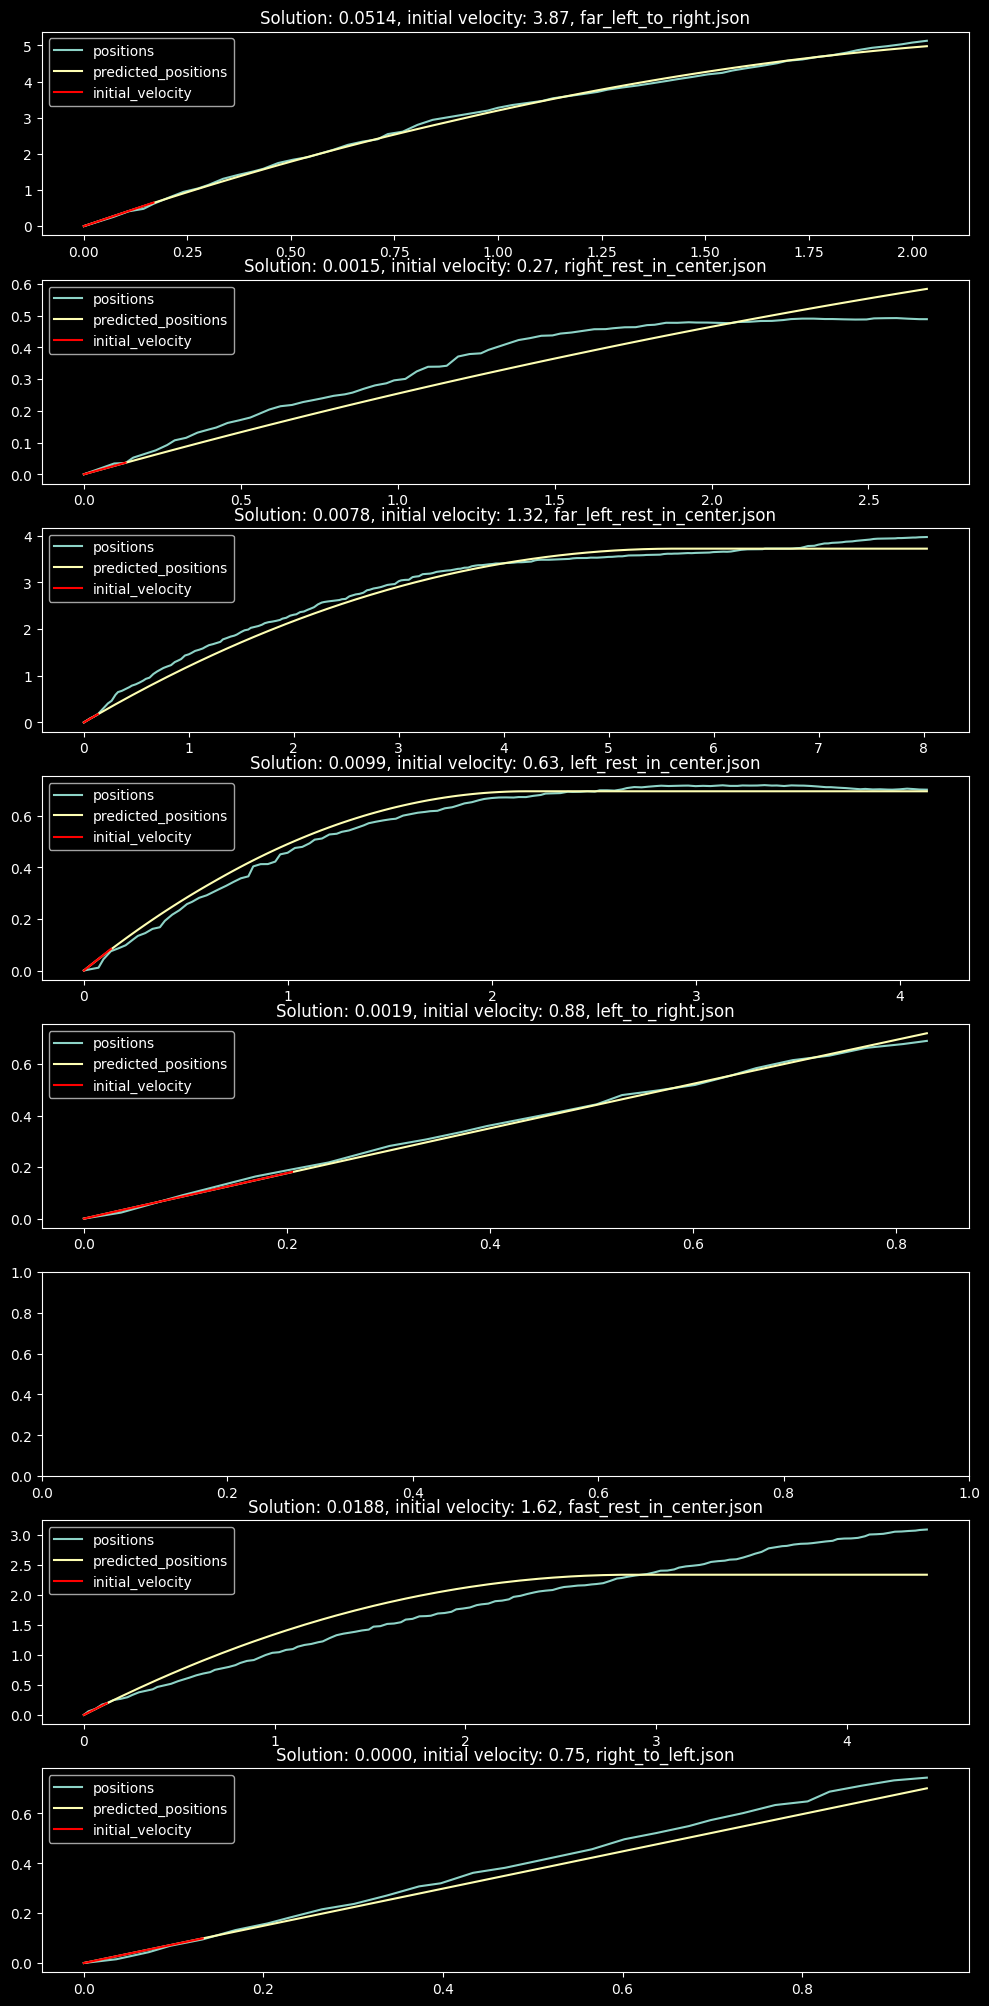

In [12]:
import os
import json
import torch
from torchmin import minimize, minimize_constr
import matplotlib.pyplot as plt


def exponential_velocity_decay_model(
    time, initial_velocity, initial_position, velocity_decay_factor
):
    position = [initial_position]
    velocity = [initial_velocity]
    for i in range(len(time) - 1):
        position.append(position[i] + velocity[i] * (time[i + 1] - time[i]))
        velocity.append(velocity[i] * velocity_decay_factor)
    return torch.concatenate(position)


def linear_friction_model(
    time, initial_velocity, initial_position, velocity_decay_factor
):
    position = [initial_position]
    velocity = [initial_velocity]
    for i in range(len(time) - 1):
        position.append(position[i] + velocity[i] * (time[i + 1] - time[i]))
        velocity.append(
            velocity[i] - velocity_decay_factor * torch.sign(velocity[i])
            if velocity_decay_factor < torch.abs(velocity[i])
            else torch.tensor([0.0])
        )
    return torch.concatenate(position)


def estimate_initial_velocity(time, positions, n_points=3):
    velocity = torch.zeros(n_points, 1)
    for i in range(n_points):
        velocity[i, :] = (positions[i + 1] - positions[i]) / (time[i + 1] - time[i])
    return torch.mean(velocity, dim=0)


def preprocess_positions(positions):
    distances = torch.sqrt(torch.sum((positions[1:] - positions[:-1]) ** 2, dim=1))
    return torch.concatenate((torch.tensor([0.0]), distances.cumsum(dim=0)))


def load_data():
    data_path = "data/"
    file_list = os.listdir(data_path)
    time_data = []
    position_data = []
    file_names = []
    for file in file_list:
        file_path = data_path + file
        with open(file_path, "r") as f:
            json_data = json.load(f)
            positions = torch.tensor(
                [json_data[i][0]["position"] for i in range(len(json_data))]
            )
            time = torch.tensor(
                [json_data[i][0]["time"] for i in range(len(json_data))]
            )
            time = time - time[0]
            positions = preprocess_positions(positions)
            time_data.append(time)
            position_data.append(positions)
            file_names.append(file)

    return time_data, position_data, file_names


time_data, position_data, file_names = load_data()
fig, axes = plt.subplots(len(time_data), 1, figsize=(10, 20))
fig.tight_layout()
for time, positions, file_name in zip(time_data, position_data, file_names):
    if file_name == "no_movement.json":
        slope = (positions[-1] - positions[0]) / (time[-1] - time[0])

for j, (time, positions, file_name) in enumerate(
    zip(time_data, position_data, file_names)
):
    if file_name == "no_movement.json":
        continue
    positions = positions - slope * time

    def objective_function(velocity_decay_factor, model):
        # Apply model to predict data
        # Calculate initial velocity
        initial_velocity = estimate_initial_velocity(time, positions, 4)
        # print(initial_velocity)
        initial_position = positions[0].reshape((1,))
        if model == "linear_friction":
            predicted_positions = linear_friction_model(
                time, initial_velocity, initial_position, velocity_decay_factor
            )
        else:
            predicted_positions = exponential_velocity_decay_model(
                time, initial_velocity, initial_position, velocity_decay_factor
            )

        residuals = predicted_positions - positions
        loss = torch.mean(torch.abs(residuals) / (time + 1.0))
        return loss, predicted_positions

    model = "linear_friction"
    initial_velocity_decay_factor = 0.01
    result = minimize(
        lambda velocity_decay_factor: objective_function(velocity_decay_factor, model)[
            0
        ],
        initial_velocity_decay_factor,
        method="bfgs",
        tol=1e-6,
    )
    best_decay_factor = torch.clamp(result.x, min=0.0)
    _, predicted_positions = objective_function(best_decay_factor, model)
    initial_velocity = estimate_initial_velocity(time, positions, 4)
    axes[j].plot(time, positions, label="positions")
    axes[j].plot(time, predicted_positions, label="predicted_positions")
    axes[j].plot(time[:5], initial_velocity * time[:5], "r", label="initial_velocity")
    axes[j].set_title(
        f"Solution: {best_decay_factor:.4f}, initial velocity: {float(initial_velocity):.2f}, {file_name}"
    )
    axes[j].legend()

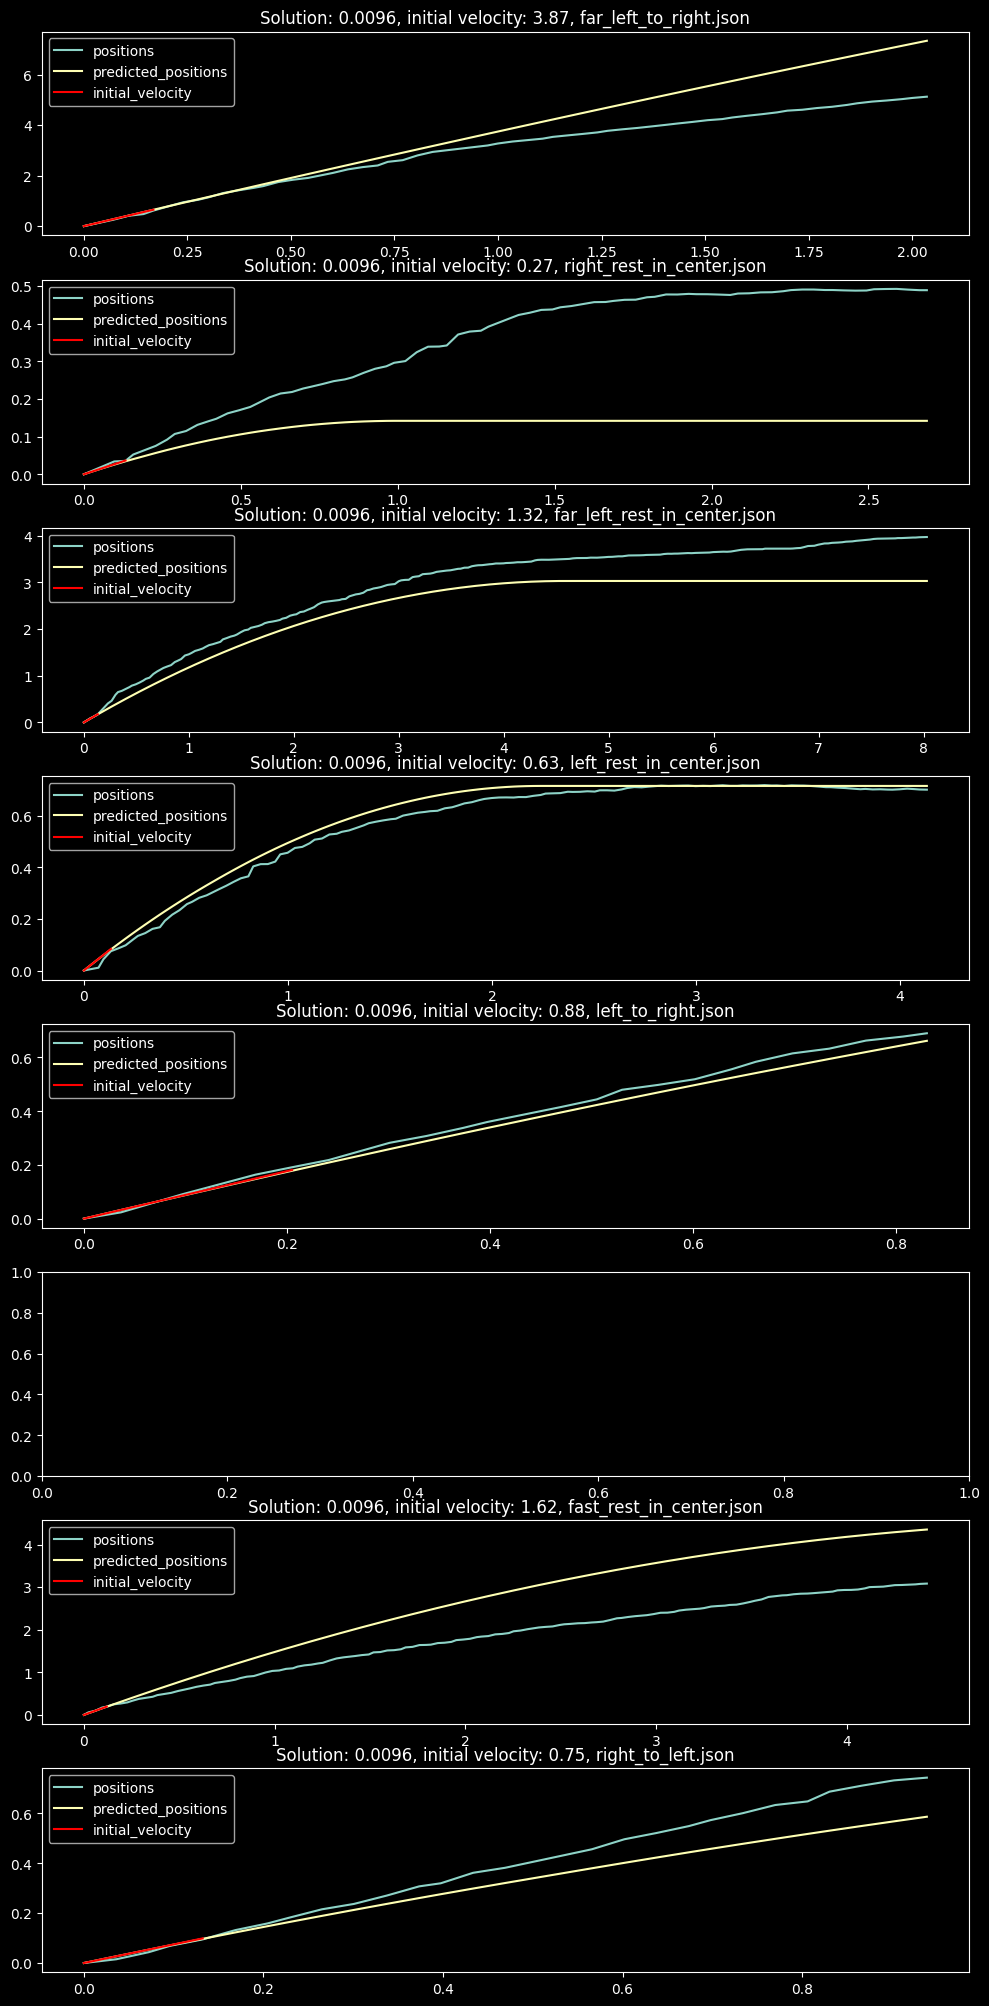

In [16]:
def total_objective_function(velocity_decay_factor, model):
    loss = torch.zeros((1,))
    for j, (time, positions, file_name) in enumerate(
        zip(time_data, position_data, file_names)
    ):
        if file_name == "no_movement.json":
            continue
        positions = positions - slope * time
        # Apply model to predict data
        # Calculate initial velocity
        initial_velocity = estimate_initial_velocity(time, positions, 4)
        # print(initial_velocity)
        initial_position = positions[0].reshape((1,))
        if model == "linear_friction":
            predicted_positions = linear_friction_model(
                time, initial_velocity, initial_position, velocity_decay_factor
            )
        else:
            predicted_positions = exponential_velocity_decay_model(
                time, initial_velocity, initial_position, velocity_decay_factor
            )

        residuals = predicted_positions - positions
        loss += torch.mean((residuals)**2 / (time + 0.01))
    return loss


model = "linear_friction"
initial_velocity_decay_factor = 0.01
result = minimize(
    lambda velocity_decay_factor: total_objective_function(velocity_decay_factor, model),
    initial_velocity_decay_factor,
    method="bfgs",
    tol=1e-6,
)
best_decay_factor = torch.clamp(result.x, min=0.0)

fig, axes = plt.subplots(len(time_data), 1, figsize=(10, 20))
fig.tight_layout()
for time, positions, file_name in zip(time_data, position_data, file_names):
    if file_name == "no_movement.json":
        slope = (positions[-1] - positions[0]) / (time[-1] - time[0])

for j, (time, positions, file_name) in enumerate(
    zip(time_data, position_data, file_names)
):
    if file_name == "no_movement.json":
        continue
    positions = positions - slope * time
    def objective_function(velocity_decay_factor, model):
        # Apply model to predict data
        # Calculate initial velocity
        initial_velocity = estimate_initial_velocity(time, positions, 4)
        # print(initial_velocity)
        initial_position = positions[0].reshape((1,))
        if model == "linear_friction":
            predicted_positions = linear_friction_model(
                time, initial_velocity, initial_position, velocity_decay_factor
            )
        else:
            predicted_positions = exponential_velocity_decay_model(
                time, initial_velocity, initial_position, velocity_decay_factor
            )

        residuals = predicted_positions - positions
        loss = torch.mean(torch.abs(residuals) / (time + 0.01))
        return loss, predicted_positions
    _, predicted_positions = objective_function(best_decay_factor, model)
    initial_velocity = estimate_initial_velocity(time, positions, 4)
    axes[j].plot(time, positions, label="positions")
    axes[j].plot(time, predicted_positions, label="predicted_positions")
    axes[j].plot(time[:5], initial_velocity * time[:5], "r", label="initial_velocity")
    axes[j].set_title(
        f"Solution: {best_decay_factor:.4f}, initial velocity: {float(initial_velocity):.2f}, {file_name}"
    )
    axes[j].legend()